In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_train = pd.read_csv('application_train.csv')

df_prev_app = pd.read_csv('previous_application.csv')
df_installments = pd.read_csv('installments_payments.csv')
df_bureau = pd.read_csv('bureau.csv')

In [2]:
# Feature Engineering

# Meringkas riwayat pinjaman sebelumnya
prev_summary = df_prev_app.groupby('SK_ID_CURR').agg({
    'AMT_ANNUITY': 'mean',
    'AMT_CREDIT': 'mean',
    'CNT_PAYMENT': 'mean'
}).reset_index()
prev_summary.columns = ['SK_ID_CURR', 'PREV_ANNUITY_AVG', 'PREV_CREDIT_AVG', 'PREV_TENOR_AVG']

# Meringkas Data Pembayaran (Installments)
df_installments['DAYS_LATE'] = df_installments['DAYS_ENTRY_PAYMENT'] - df_installments['DAYS_INSTALMENT']
inst_summary = df_installments.groupby('SK_ID_CURR')['DAYS_LATE'].mean().reset_index()
inst_summary.columns = ['SK_ID_CURR', 'AVG_DAYS_LATE']

# Data Merging dan Cleaning
df_final = df_train.merge(prev_summary, on='SK_ID_CURR', how='left')
df_final = df_final.merge(inst_summary, on='SK_ID_CURR', how='left')

df_final = df_final.fillna(0) # mengisi data kosong dengan 0

C:\Users\ACER\AppData\Local\Temp\ipykernel_8936\1647109105.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TARGET', data=df_final, palette='viridis')


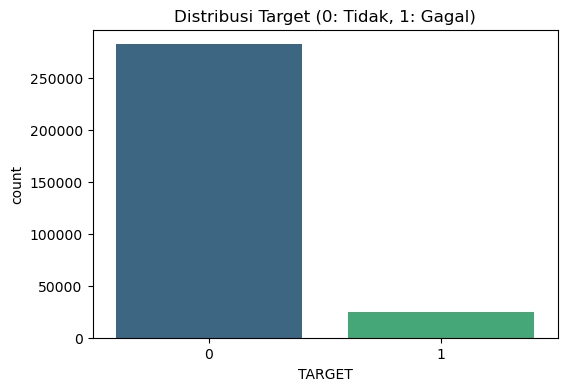

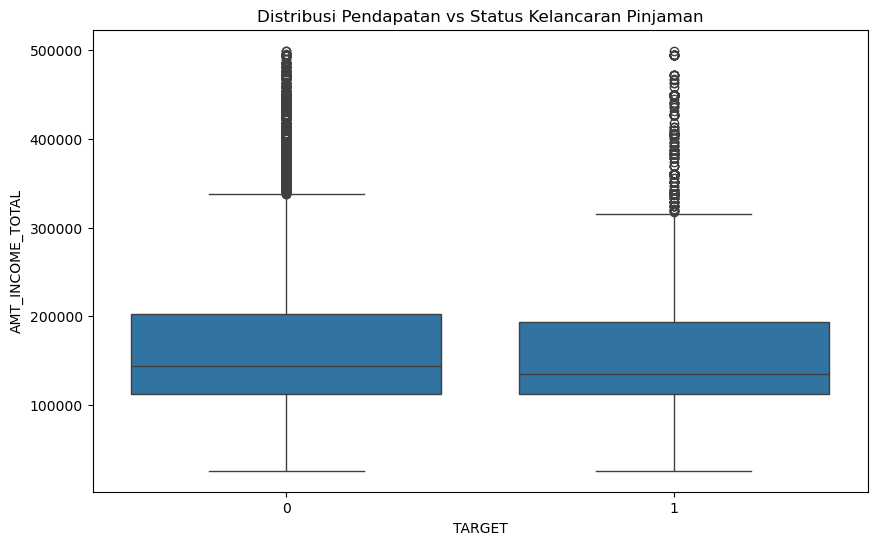

In [5]:
# A. Visualisasi Distribusi Target (Gagal vs Tidak)
plt.figure(figsize=(6,4))
sns.countplot(x='TARGET', data=df_final, palette='viridis')
plt.title('Distribusi Target (0: Tidak, 1: Gagal)')
plt.show()

# B. Visualisasi Hubungan Pendapatan vs Target
plt.figure(figsize=(10,6))
sns.boxplot(x='TARGET', y='AMT_INCOME_TOTAL', data=df_final[df_final['AMT_INCOME_TOTAL'] < 500000])
plt.title('Distribusi Pendapatan vs Status Kelancaran Pinjaman')
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer

# Pemodelan Algoritma Logistic Regression dan Random Forest
features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY']

X = df_final[features]
y = df_final['TARGET'] 

# Mengatasi data kosong (Imputing)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split data 80% Train, 20% Test - SEKARANG SUDAH TIDAK ERROR
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# 1. LOGISTIC REGRESSION
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_probs = lr_model.predict_proba(X_test)[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)

# 2. RANDOM FOREST 
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
rf_probs = rf_model.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_probs)

print(f"AUC Logistic Regression: {lr_auc:.4f}")
print(f"AUC Random Forest: {rf_auc:.4f}")

AUC Logistic Regression: 0.5334
AUC Random Forest: 0.6041


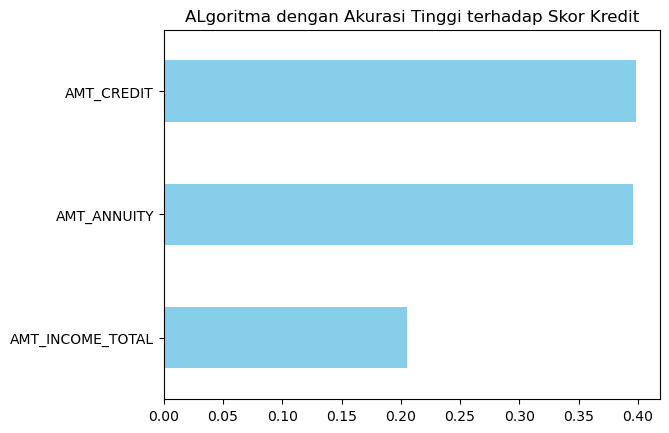

In [10]:
# Visualisasi ALgoritma dengan Akurasi Tertinggi (Random Forest)
importances = pd.Series(rf_model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', color='skyblue')
plt.title('ALgoritma dengan Akurasi Tinggi terhadap Skor Kredit')
plt.show()